#Imports & basic config

In [1]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire sentence-transformers datasets


In [3]:
import transformers
print(transformers.__version__)


4.57.2


In [4]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UW_Courses/eep596 dl/final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/UW_Courses/eep596 dl/final_project


In [5]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import urllib.request
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

# Models
from transformers import BertTokenizer, BertModel
# [NEW] Import CLIP components
from transformers import CLIPVisionModel, CLIPImageProcessor
from sentence_transformers import SentenceTransformer, util

# Torch Utils
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
# Removed manual checkpoint import, using native HF checkpointing
import kagglehub


In [6]:

# ==========================================
# 2. Configuration
# ==========================================
class Config:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # [ADJUSTED] Training Config for ViT-Large
    # ViT-Large is heavy, reducing batch size to prevent OOM on T4
    batch_size = 16
    num_epochs = 30
    learning_rate = 1e-5   # Lower LR for larger model
    weight_decay = 1e-4
    max_len = 64
    patience = 10

    # Model ID
    clip_model_id = "openai/clip-vit-large-patch14"

    # Paths
    checkpoint_dir = Path("./daquar_clip_checkpoints")
    best_model_path = checkpoint_dir / "best_model.pth"
    resume_path = checkpoint_dir / "latest_checkpoint.pth"

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(Config.seed)
Config.checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Device: {Config.device}")

Device: cuda


#VQADataset + training wrapper dataset

In [7]:

# ==========================================
# 3. Data Preparation (Via KaggleHub)
# ==========================================
def prepare_daquar_data():
    print("Downloading DAQUAR dataset from Kaggle...")

    try:
        kagglehub.login()
    except:
        pass

    try:
        dataset_path = kagglehub.dataset_download("bhavikardeshna/visual-question-answering-computer-vision-nlp")
        root_dir = Path(dataset_path)
    except Exception as e:
        raise RuntimeError(f"Failed to download dataset: {e}")

    dataset_dir = root_dir / "dataset"
    if not dataset_dir.exists():
        if (root_dir / "images").exists(): dataset_dir = root_dir

    image_dir = dataset_dir / "images"

    train_csv = dataset_dir / "data_train.csv"
    eval_csv = dataset_dir / "data_eval.csv"

    dfs = []
    if train_csv.exists(): dfs.append(pd.read_csv(train_csv))
    if eval_csv.exists(): dfs.append(pd.read_csv(eval_csv))
    df = pd.concat(dfs, ignore_index=True)

    # Clean Data
    if 'label' in df.columns: df = df.rename(columns={'label': 'answer'})

    def get_image_path(img_id):
        img_id = str(img_id).strip()
        path_png = image_dir / f"{img_id}.png"
        path_jpg = image_dir / f"{img_id}.jpg"
        if path_png.exists(): return str(path_png)
        if path_jpg.exists(): return str(path_jpg)
        return None

    df['image_path'] = df['image_id'].apply(get_image_path)
    df = df.dropna(subset=['image_path'])
    df['question'] = df['question'].astype(str).str.strip()
    df['answer'] = df['answer'].astype(str).str.strip()

    return df

print("Preparing Data...")
full_df = prepare_daquar_data()
print(f"Total valid samples: {len(full_df)}")

train_df, temp_df = train_test_split(full_df, test_size=0.2, random_state=Config.seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=Config.seed)

# Build Vocabulary
all_answers = full_df['answer'].tolist()
counter = Counter(all_answers)
vocab = sorted(counter.keys())
answer2idx = {ans: i for i, ans in enumerate(vocab)}
idx2answer = {i: ans for i, ans in enumerate(vocab)}
NUM_ANSWERS = len(answer2idx)

Preparing Data...


100%|██████████| 411M/411M [00:10<00:00, 40.6MB/s]

Extracting files...


Total valid samples: 12468


#Prepare Kaggle VQA data → JSON + 80/10/10 split

In [8]:

# ==========================================
# 4. Dataset & Processor (CLIP)
# ==========================================

# [NEW] Use CLIPImageProcessor instead of manual transforms
# This handles the specific normalization and resizing for CLIP
image_processor = CLIPImageProcessor.from_pretrained(Config.clip_model_id)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class DaquarCLIPDataset(Dataset):
    def __init__(self, df, image_processor, tokenizer, answer2idx, max_len=64):
        self.df = df
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.answer2idx = answer2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 1. Image
        img_path = row['image_path']
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224))

        # [NEW] Process image using CLIP processor
        # returns: {'pixel_values': tensor [1, 3, 224, 224]}
        img_inputs = self.image_processor(images=image, return_tensors="pt")
        pixel_values = img_inputs['pixel_values'].squeeze(0)

        # 2. Text
        encoding = self.tokenizer(
            str(row['question']),
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # 3. Label
        label = self.answer2idx.get(str(row['answer']), 0)

        return pixel_values, input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Create DataLoaders
train_ds = DaquarCLIPDataset(train_df, image_processor, tokenizer, answer2idx)
val_ds = DaquarCLIPDataset(val_df, image_processor, tokenizer, answer2idx)
test_ds = DaquarCLIPDataset(test_df, image_processor, tokenizer, answer2idx)

# [NOTE] num_workers=0 for Colab stability
train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=0)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#Model Training

In [10]:

# ==========================================
# 5. Model Architecture (CLIP-Large + BERT)
# ==========================================
class CLIPLarge_BERT_VQA(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        # [NEW] Visual Encoder: CLIP ViT-Large
        print(f"Loading Visual Encoder: {Config.clip_model_id} ...")
        self.vision_encoder = CLIPVisionModel.from_pretrained(Config.clip_model_id)

        # Text Encoder: BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # [CRITICAL FIX] Enable Native Gradient Checkpointing
        # This is much more stable than manual torch.utils.checkpoint
        self.vision_encoder.gradient_checkpointing_enable()
        self.bert.gradient_checkpointing_enable()

        # [NEW] Fusion Dimension Calculation
        # CLIP ViT-Large output dim = 1024
        # BERT Base output dim = 768
        # Combined = 1792
        self.fc1 = nn.Linear(1024 + 768, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_answers)

    def forward(self, pixel_values, input_ids, attention_mask):
        # 1. Vision Path (Native Checkpointing handles memory)
        vision_out = self.vision_encoder(pixel_values=pixel_values)
        # pooler_output is [Batch, 1024]
        img_feat = vision_out.pooler_output

        # 2. Text Path (Native Checkpointing handles memory)
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        txt_feat = bert_out.last_hidden_state[:, 0, :] # [Batch, 768]

        # 3. Fusion
        combined = torch.cat((img_feat, txt_feat), dim=1)

        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

model = CLIPLarge_BERT_VQA(NUM_ANSWERS).to(Config.device)

Loading Visual Encoder: openai/clip-vit-large-patch14 ...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:

# ==========================================
# 6. Training Loop (With Resume)
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)
scaler = GradScaler()

start_epoch = 0
best_val_acc = 0.0
early_stopping_counter = 0
history = []

if Config.resume_path.exists():
    print(f"🔄 Found checkpoint. Resuming...")
    ckpt = torch.load(Config.resume_path, map_location=Config.device)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    if 'scaler_state_dict' in ckpt: scaler.load_state_dict(ckpt['scaler_state_dict'])
    start_epoch = ckpt['epoch'] + 1
    best_val_acc = ckpt['best_val_acc']
    early_stopping_counter = ckpt['early_stopping_counter']
    history = ckpt.get('history', [])
    print(f"   >>> Resuming from Epoch {start_epoch+1}")
else:
    print("🚀 Starting training from scratch.")

print("Starting Training...")

for epoch in range(start_epoch, Config.num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for imgs, ids, mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

        # [CRITICAL FIX] Enable gradients for input images to start the gradient chain
        # This is required when using gradient checkpointing on the first layer
        imgs.requires_grad_(True)

        optimizer.zero_grad()

        with autocast("cuda"):
            outputs = model(imgs, ids, mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, ids, mask, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

            with autocast("cuda"):
                outputs = model(imgs, ids, mask)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | Val Loss={avg_val_loss:.4f} Acc={val_acc:.4f}")

    history.append({"epoch": epoch+1, "train_loss": avg_train_loss, "val_loss": avg_val_loss, "train_acc": train_acc, "val_acc": val_acc})

    # Save Best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0
        torch.save({'model_state_dict': model.state_dict()}, Config.best_model_path)
        print(f">>> 🌟 New Best Model Saved! Acc: {best_val_acc:.4f}")
    else:
        early_stopping_counter += 1
        print(f"   >>> Counter: {early_stopping_counter}/{Config.patience}")

    # Save Checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_acc': best_val_acc,
        'early_stopping_counter': early_stopping_counter,
        'history': history
    }, Config.resume_path)

    if early_stopping_counter >= Config.patience:
        print("🛑 Early stopping.")
        break


🔄 Found checkpoint. Resuming...
   >>> Resuming from Epoch 21
Starting Training...


Epoch 21 [Train]:   0%|          | 0/624 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.7597 Acc=0.8325 | Val Loss=4.9253 Acc=0.2654
   >>> Counter: 6/10


Epoch 22 [Train]:   0%|          | 0/624 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.7297 Acc=0.8375 | Val Loss=4.9936 Acc=0.2694
   >>> Counter: 7/10


Epoch 23 [Train]:   0%|          | 0/624 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.6901 Acc=0.8514 | Val Loss=4.9597 Acc=0.2686
   >>> Counter: 8/10


Epoch 24 [Train]:   0%|          | 0/624 [00:00<?, ?it/s]

#Evaluation


Running Final Evaluation...
Loading best CLIP model from daquar_clip_checkpoints/best_model.pth...
Evaluating CLIP-Large...


CLIP-Large:   0%|          | 0/78 [00:00<?, ?it/s]


🔄 Found ResNet50 baseline at daquar_checkpoints/best_model.pth. Starting comparison...
Evaluating ResNet50...


ResNet50:   0%|          | 0/78 [00:00<?, ?it/s]


=== Final Comparison ===
        Model  Accuracy  SBERT_Sim
0  CLIP-Large  0.295108   0.518820
1    ResNet50  0.281476   0.507408


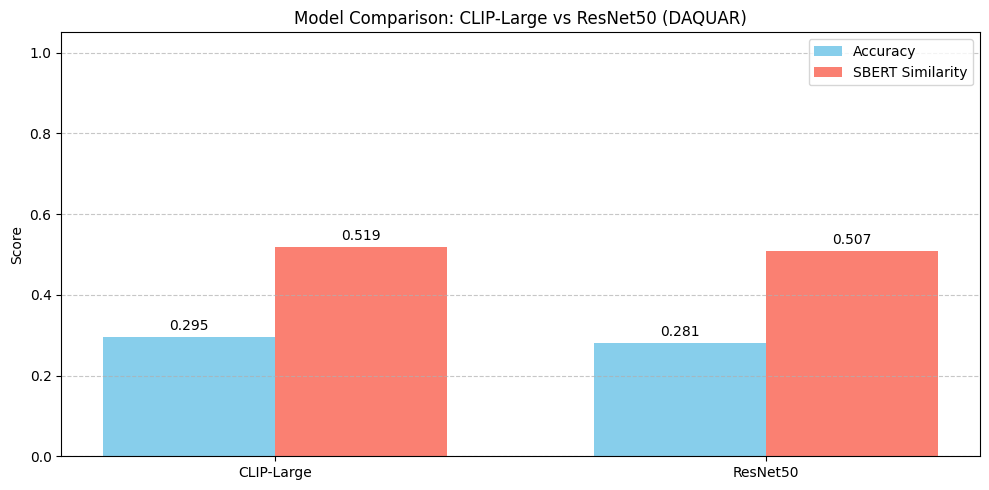

In [11]:
# Models
# [FIX] Re-add torchvision imports for ResNet baseline comparison
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
# [NEW] Import CLIP components
from transformers import CLIPVisionModel, CLIPImageProcessor
from sentence_transformers import SentenceTransformer, util

# Torch Utils
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
# Removed manual checkpoint import, using native HF checkpointing
import kagglehub

# ==========================================
# 7. Evaluation
# ==========================================
# 7. Comparative Evaluation (CLIP vs ResNet50)
# ==========================================
print("\nRunning Final Evaluation...")
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# --- Helper: Evaluation Loop ---
def evaluate_model_on_dataset(model, dataloader, device, idx2answer, name="Model"):
    model.eval()
    predictions = []
    ground_truths = []
    similarities = []

    print(f"Evaluating {name}...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=name):
            # Unpack batch (works for both datasets as they return same tuple structure)
            # imgs can be pixel_values (CLIP) or raw tensors (ResNet)
            imgs, ids, mask, labels = batch

            imgs = imgs.to(device)
            ids = ids.to(device)
            mask = mask.to(device)
            labels = labels.to(device)

            with autocast("cuda"):
                outputs = model(imgs, ids, mask)

            _, preds = torch.max(outputs, 1)

            for p_idx, g_idx in zip(preds, labels):
                pred_text = idx2answer[p_idx.item()]
                gt_text = idx2answer[g_idx.item()]

                predictions.append(pred_text)
                ground_truths.append(gt_text)

                emb1 = sbert_model.encode(pred_text, convert_to_tensor=True)
                emb2 = sbert_model.encode(gt_text, convert_to_tensor=True)
                sim = util.cos_sim(emb1, emb2).item()
                similarities.append(sim)

    df = pd.DataFrame({
        "gt_answer": ground_truths,
        "pred_answer": predictions,
        "similarity": similarities
    })
    # Normalize check
    df['is_correct'] = df.apply(lambda x: 1 if x['gt_answer'].lower().strip() == x['pred_answer'].lower().strip() else 0, axis=1)
    return df

# --- 1. Evaluate CLIP-Large (Current Model) ---
if Config.best_model_path.exists():
    print(f"Loading best CLIP model from {Config.best_model_path}...")
    # Handle state dict wrapper if needed
    ckpt = torch.load(Config.best_model_path, map_location=Config.device)
    if 'model_state_dict' in ckpt:
        model.load_state_dict(ckpt['model_state_dict'])
    else:
        model.load_state_dict(ckpt)
else:
    print("Best CLIP model not found, using current weights.")

df_clip = evaluate_model_on_dataset(model, test_loader, Config.device, idx2answer, name="CLIP-Large")

# --- 2. Evaluate ResNet50 (Baseline) if available ---
resnet_checkpoint_path = Path("./daquar_checkpoints/best_model.pth")
df_resnet = None

if resnet_checkpoint_path.exists():
    print(f"\n🔄 Found ResNet50 baseline at {resnet_checkpoint_path}. Starting comparison...")

    # Define ResNet Model Architecture (Same as previous script)
    class ResNetBERT_VQA(nn.Module):
        def __init__(self, num_answers):
            super().__init__()
            self.cnn = models.resnet50(weights=None) # No need to download weights, we load checkpoint
            self.cnn.fc = nn.Identity()
            self.bert = BertModel.from_pretrained('bert-base-uncased')
            self.fc1 = nn.Linear(2048 + 768, 1024)
            self.dropout = nn.Dropout(0.5)
            self.fc2 = nn.Linear(1024, num_answers)

        def forward(self, images, input_ids, attention_mask):
            img_feat = self.cnn(images)
            bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            txt_feat = bert_out.last_hidden_state[:, 0, :]
            combined = torch.cat((img_feat, txt_feat), dim=1)
            x = self.fc1(combined)
            x = torch.relu(x)
            x = self.dropout(x)
            return self.fc2(x)

    # Instantiate & Load
    resnet_model = ResNetBERT_VQA(NUM_ANSWERS).to(Config.device)

    # Load weights safely
    ckpt_res = torch.load(resnet_checkpoint_path, map_location=Config.device)
    if 'model_state_dict' in ckpt_res:
        resnet_model.load_state_dict(ckpt_res['model_state_dict'])
    else:
        resnet_model.load_state_dict(ckpt_res)

    # Create ResNet specific DataLoader (Standard Transforms)
    resnet_val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Simple Dataset Wrapper for ResNet
    class ResNetEvalDataset(Dataset):
        def __init__(self, df, transform, tokenizer, answer2idx, max_len=64):
            self.df = df
            self.transform = transform
            self.tokenizer = tokenizer
            self.answer2idx = answer2idx
            self.max_len = max_len
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            try:
                image = Image.open(row['image_path']).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224))
            image = self.transform(image)
            encoding = self.tokenizer(str(row['question']), return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_len)
            label = self.answer2idx.get(str(row['answer']), 0)
            return image, encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0), torch.tensor(label, dtype=torch.long)

    resnet_ds = ResNetEvalDataset(test_df, resnet_val_transform, tokenizer, answer2idx)
    resnet_loader = DataLoader(resnet_ds, batch_size=Config.batch_size, shuffle=False, num_workers=0)

    # Evaluate
    df_resnet = evaluate_model_on_dataset(resnet_model, resnet_loader, Config.device, idx2answer, name="ResNet50")

else:
    print(f"\n⚠️ ResNet checkpoint not found at {resnet_checkpoint_path}. Skipping comparison.")

# --- 3. Visualize Comparison ---
metrics = {'Model': [], 'Accuracy': [], 'SBERT_Sim': []}

# Add CLIP results
metrics['Model'].append('CLIP-Large')
metrics['Accuracy'].append(df_clip['is_correct'].mean())
metrics['SBERT_Sim'].append(df_clip['similarity'].mean())

# Add ResNet results
if df_resnet is not None:
    metrics['Model'].append('ResNet50')
    metrics['Accuracy'].append(df_resnet['is_correct'].mean())
    metrics['SBERT_Sim'].append(df_resnet['similarity'].mean())

df_metrics = pd.DataFrame(metrics)
print("\n=== Final Comparison ===")
print(df_metrics)
print("="*30)

# Bar Chart
plt.figure(figsize=(10, 5))
x = np.arange(len(df_metrics['Model']))
width = 0.35

plt.bar(x - width/2, df_metrics['Accuracy'], width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, df_metrics['SBERT_Sim'], width, label='SBERT Similarity', color='salmon')

plt.ylabel('Score')
plt.title('Model Comparison: CLIP-Large vs ResNet50 (DAQUAR)')
plt.xticks(x, df_metrics['Model'])
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i in x:
    acc = df_metrics['Accuracy'][i]
    sim = df_metrics['SBERT_Sim'][i]
    plt.text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, sim + 0.01, f'{sim:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()